### Data exploration


In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

from data_processing import *

%load_ext autoreload
%autoreload 2


In [2]:
X, y = get_data()
X.head()
#Unnamed: 0 is the Id of the row


,Unnamed: 0,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,Age,Education,Income,BMI_Category,Healthy_Diet,Mental_Health_Risk,Heart_Disease_Risk,Age_Group,Education_Level,Income_Group
0,31141,0,1,1,20.693674,1,0,0,1,1,...,11.725312,6.0,8.0,Normal weight,1,0,2,Young,Some College,High Income
1,98230,0,0,1,28.375985,0,0,0,1,0,...,7.977719,5.0,8.0,Obese,0,0,0,Young,Some College,High Income
2,89662,1,1,1,24.629353,0,0,0,1,1,...,8.161838,5.0,6.0,Normal weight,1,0,2,Young,Some College,Middle Income
3,208255,0,1,1,27.246610,0,0,0,1,1,...,5.038298,6.0,7.0,Overweight,1,0,1,Young,Some College,High Income
4,233415,0,1,1,23.671678,0,0,0,1,1,...,12.037360,4.0,6.0,Normal weight,1,0,1,Young,High School Graduate,Middle Income


In [3]:
print('Number of elements :', len(X))
print('Number of features :', len(X.columns))

Number of elements : 202944
Number of features : 29


In [4]:
y.head()

,Unnamed: 0,Diabetes_binary
0,31141,0
1,98230,0
2,89662,1
3,208255,0
4,233415,0


In [5]:
print('len(y):', len(y))

len(y): 202944


In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202944 entries, 0 to 202943
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            202944 non-null  int64  
 1   HighBP                202944 non-null  int64  
 2   HighChol              202944 non-null  int64  
 3   CholCheck             202944 non-null  int64  
 4   BMI                   202944 non-null  float64
 5   Smoker                202944 non-null  int64  
 6   Stroke                202944 non-null  int64  
 7   HeartDiseaseorAttack  202944 non-null  int64  
 8   PhysActivity          202944 non-null  int64  
 9   Fruits                202944 non-null  int64  
 10  Veggies               202944 non-null  int64  
 11  HvyAlcoholConsump     202944 non-null  int64  
 12  AnyHealthcare         202944 non-null  int64  
 13  NoDocbcCost           202944 non-null  int64  
 14  GenHlth               202944 non-null  int64  
 15  

In [7]:
X.isnull().sum()

Unnamed: 0              0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
BMI_Category            0
Healthy_Diet            0
Mental_Health_Risk      0
Heart_Disease_Risk      0
Age_Group               0
Education_Level         0
Income_Group            0
dtype: int64

In [8]:
unique_values = {}
for col in X.columns:
    unique_values[col] = X[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

,unique value count
Unnamed: 0,202944
HighBP,2
HighChol,2
CholCheck,2
BMI,182669
Smoker,2
Stroke,2
HeartDiseaseorAttack,2
PhysActivity,2
Fruits,2


C:\Users\sidne\AppData\Local\Temp\ipykernel_9208\3973944247.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = col, data = X ,palette='Set2')
C:\Users\sidne\AppData\Local\Temp\ipykernel_9208\3973944247.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = col, data = X ,palette='Set2')
C:\Users\sidne\AppData\Local\Temp\ipykernel_9208\3973944247.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = col, data = X ,palette='Set2')
C:\Users\sidne\AppData\Local\Temp\ipykernel_9208\3973944247.py:5: FutureWarning: 

Passing `palette` witho

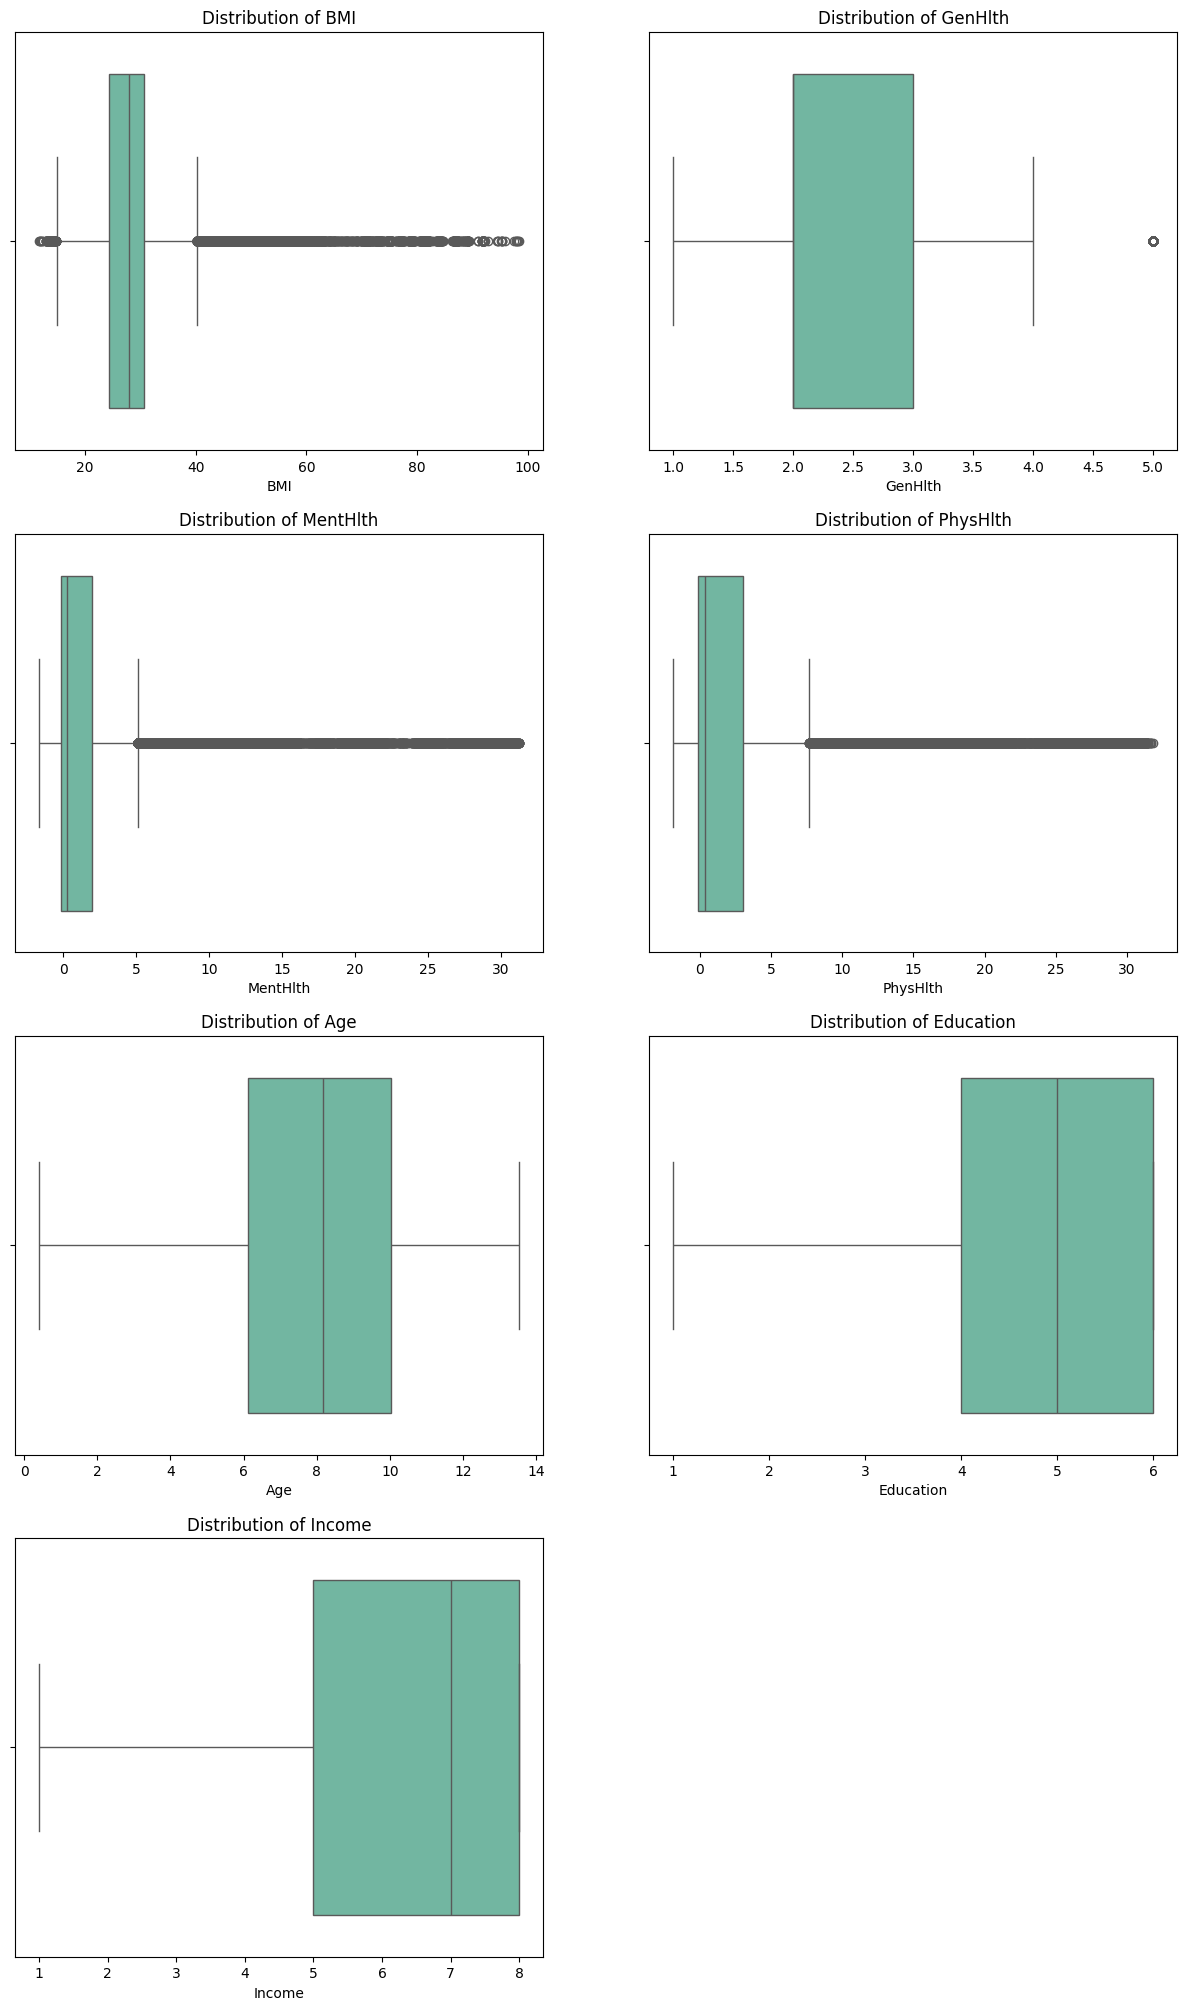

In [12]:
plt.figure(figsize = (15,25))
for i,col in enumerate(['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age','Education', 'Income']):
    plt.subplot(4,2,i+1)
    plt.title('Distribution of '+col)
    sns.boxplot(x = col, data = X ,palette='Set2')
plt.show()

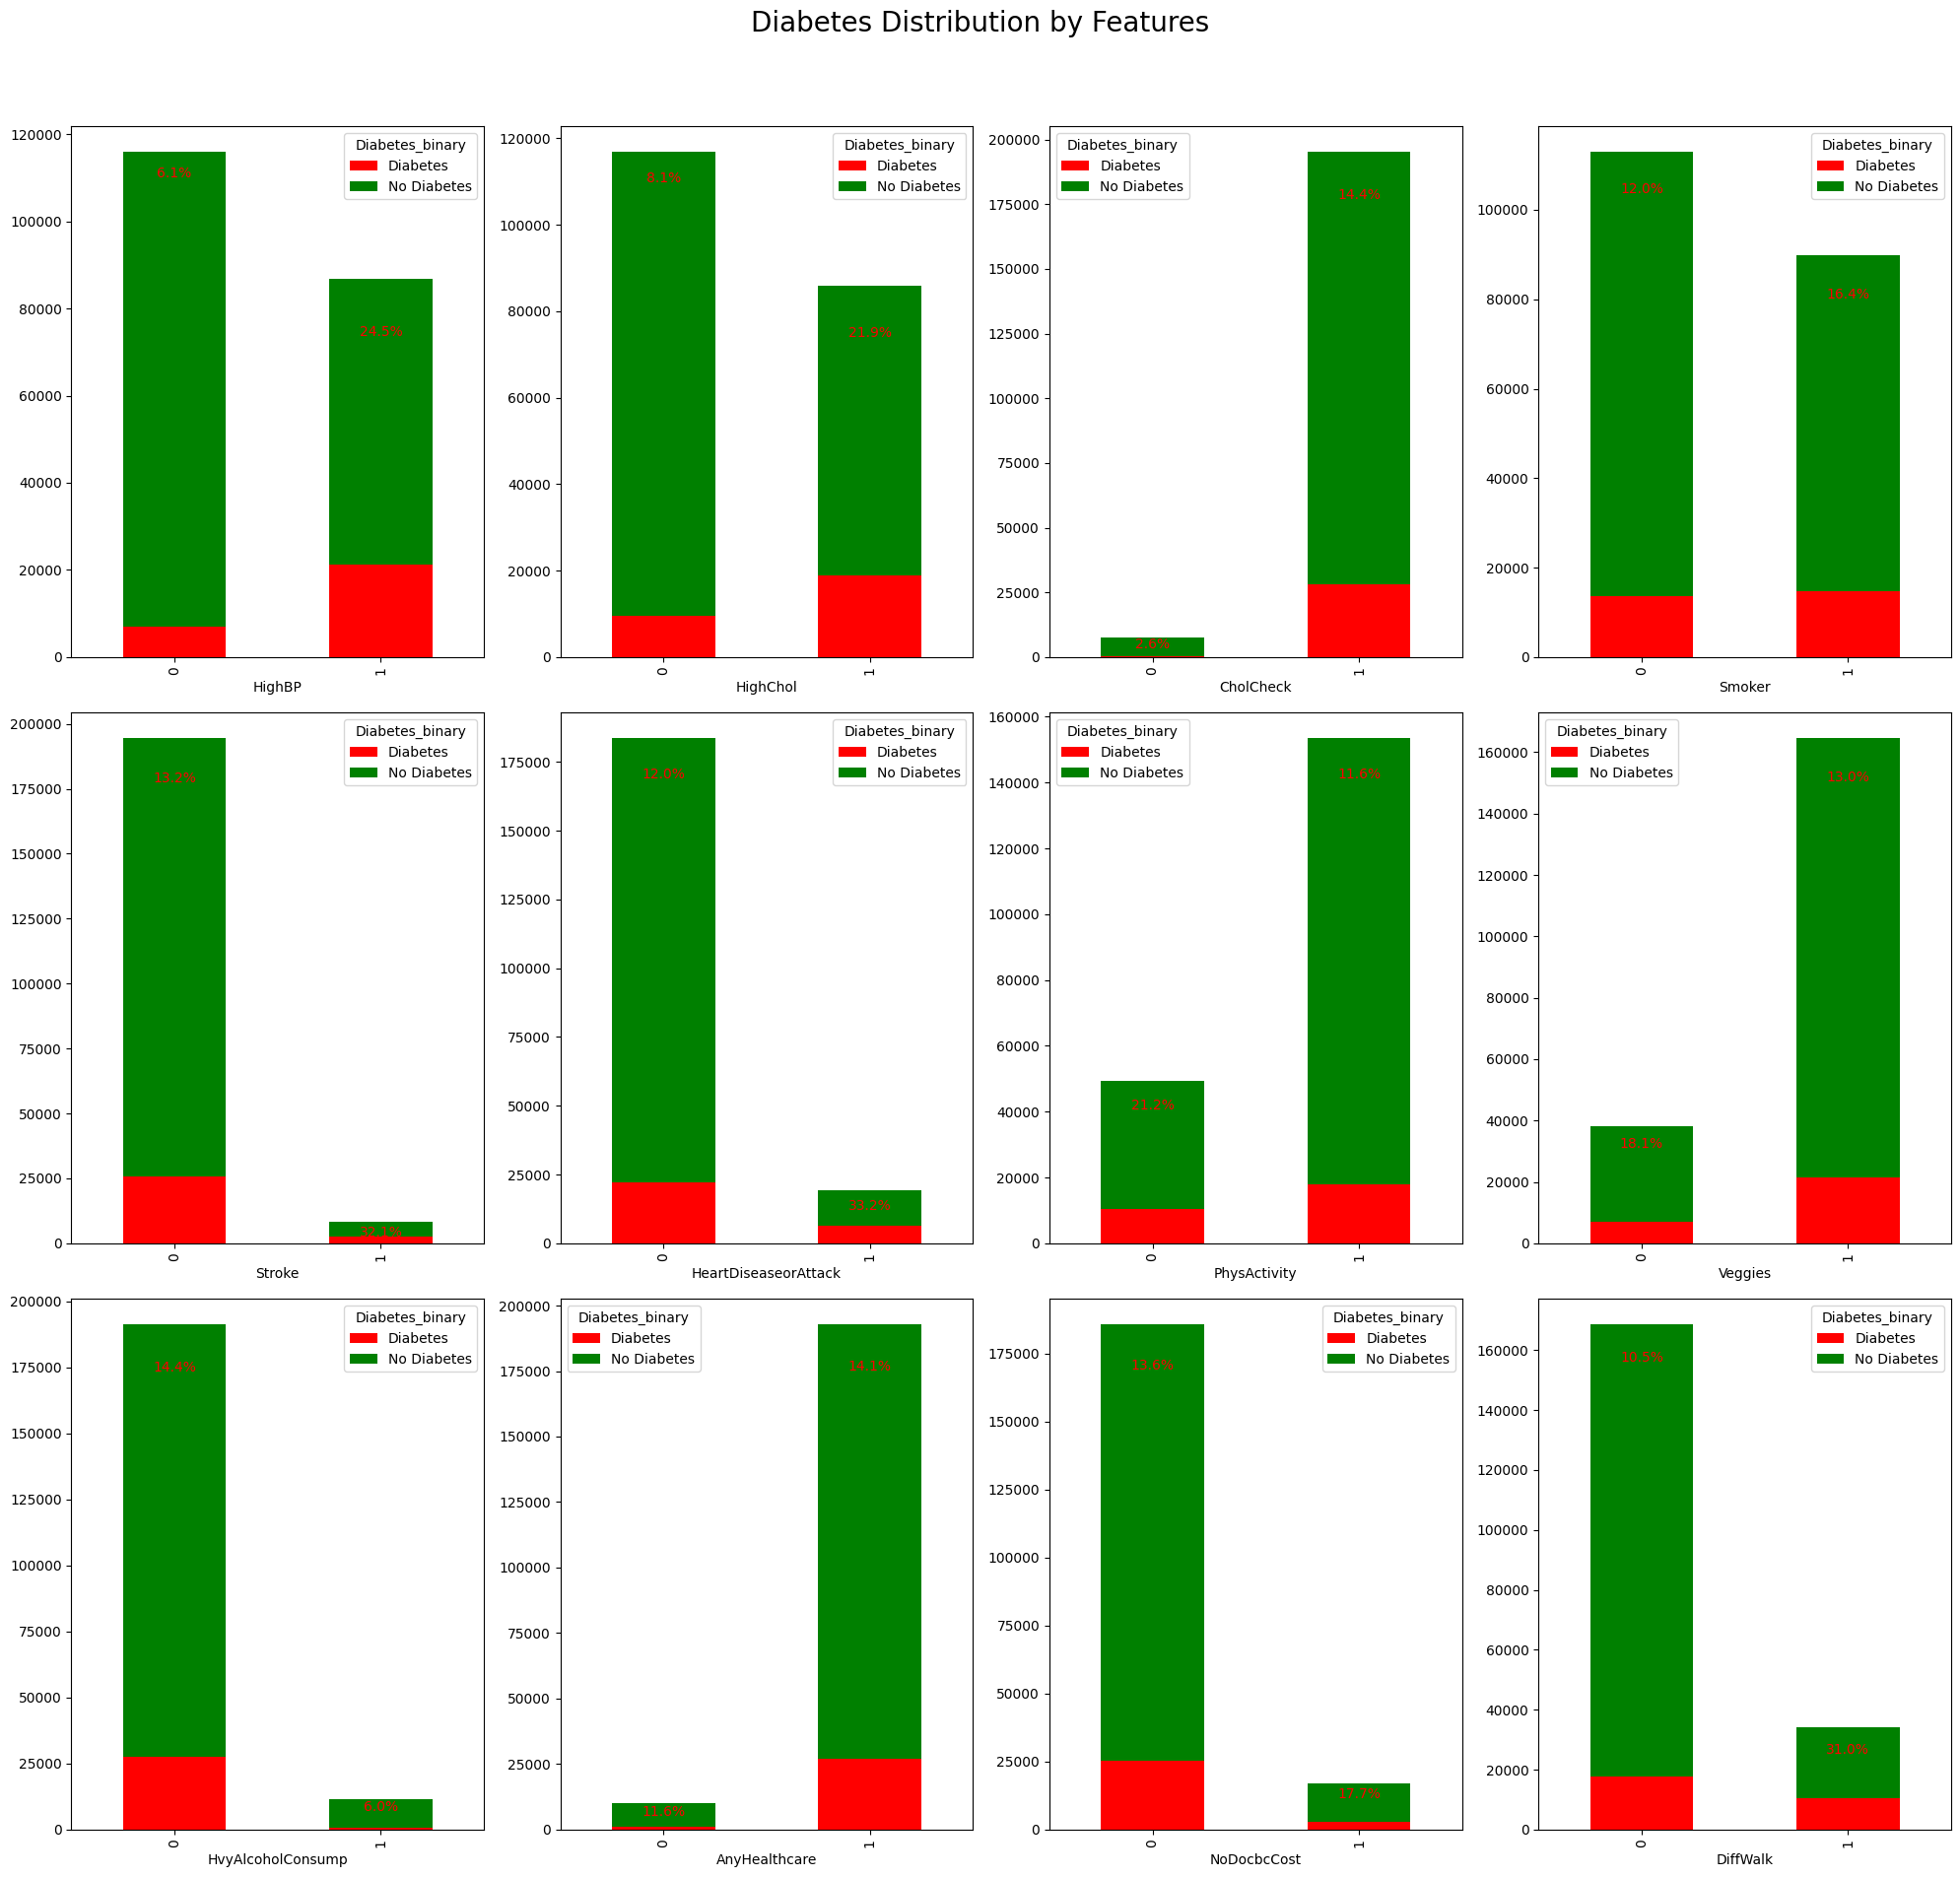

In [45]:
cols = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 
        'PhysActivity', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk']

def create_plot_pivot(data, x_column):
    """Create a pivot table for satisfaction versus another rating for easy plotting."""
    # Merge `X` and `y` to ensure access to 'Diabetes_binary' column for grouping
    data_with_target = data.copy()
    data_with_target['Diabetes_binary'] = y['Diabetes_binary']
    data_with_target['Diabetes_binary'] = data_with_target['Diabetes_binary'].replace({0: 'No Diabetes', 1: 'Diabetes'})
    
    _df_plot = data_with_target.groupby([x_column, 'Diabetes_binary']).size() \
                   .reset_index().pivot(columns='Diabetes_binary', index=x_column, values=0)
    return _df_plot

fig, ax = plt.subplots(3, 4, figsize=(20, 20))
axe = ax.ravel()
c = len(cols)
plt.suptitle('Diabetes Distribution by Features', fontsize=20)

# Custom colors for the plot
custom_colors = {'No Diabetes': 'green', 'Diabetes': 'red'}

# Plotting each column in cols
for i in range(c):
    plot_data = create_plot_pivot(X, cols[i])
    plot_data.plot(kind='bar', stacked=True, ax=axe[i], color=[custom_colors[val] for val in plot_data.columns])
    axe[i].set_xlabel(cols[i])
    
    # Adding percentage labels for the "Diabetes" (red) part of each bar
    for j, (index, row) in enumerate(plot_data.iterrows()):
        total = row['No Diabetes'] + row['Diabetes']  # Sum of "No Diabetes" and "Diabetes" counts
        if total > 0:
            diabetes_percentage = (row['Diabetes'] / total) * 100  # Calculate percentage for Diabetes
            axe[i].text(j, row['No Diabetes'] + row['Diabetes'] / 2, 
                        f"{diabetes_percentage:.1f}%", color="red", ha="center", va="top")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
plt.show()


### Process the data

In [46]:
# Look for multicollinearity between the features and remove the features that are unnecessary
# we already know the age so age_group is not needed
X = X.drop(columns=['Unnamed: 0', 'Age_Group', 'MentHlth', 'HvyAlcoholConsump'])
# correlation_matrix = X.corr() #TODO


In [ ]:
X = feature_encoding(X)